In [ ]:
import numpy as np
from qiskit.circuit.library import RXGate, SXGate, IGate, CRXGate
from qiskit.quantum_info import Operator

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import Layout, InstructionProperties
from qiskit_ibm_runtime.fake_provider import FakeJakartaV2
from qiskit.circuit import Qubit, QuantumRegister, QuantumCircuit, ParameterVector
from qiskit_experiments.library.tomography.basis import (
    PauliPreparationBasis,
    Pauli6PreparationBasis,
)
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer import AerSimulator
import qiskit_aer.noise as noise


phi = np.pi/4 # rotation angle
gamma = 0.01 # spillover rate for the CRX gate
custom_rx_gate_label = 'custom_kron(rx,ident)_gate'

noise_model = noise.NoiseModel()
coherent_crx_noise = noise.coherent_unitary_error(CRXGate(gamma*phi))
noise_model.add_quantum_error(coherent_crx_noise, [custom_rx_gate_label], [0, 1])
noise_model.add_basis_gates(['unitary'])

generic_backend = GenericBackendV2(num_qubits=2, dtm=2.2222*1e-10, basis_gates=["cx", "id", "rz", "sx", "x", "crx"])
backend = AerSimulator.from_backend(
    generic_backend,
    noise_model=noise_model)

pm = generate_preset_pass_manager(
    optimization_level=1,
    backend=backend, # FakeJakartaV2(),
    initial_layout=Layout({
        0: Qubit(QuantumRegister(2, 'q'), 0),
        1: Qubit(QuantumRegister(2, 'q'), 1)
    }),
)

params = ParameterVector('a', 1)
qc = QuantumCircuit(2)
rx_op = Operator(RXGate(phi))
identity_op = Operator(IGate())
rx_op_2q = Operator(identity_op.tensor(rx_op))
qc.unitary(rx_op_2q, [0, 1], label=custom_rx_gate_label)

input_state_circ = QuantumCircuit(2)
# PauliPrepYp
input_state_circ.h(0)
input_state_circ.s(0)
# PauliPrepXp
input_state_circ.h(1)

print(input_state_circ)


# full_circ = pm.run(qc.compose(input_state_circ, inplace=False, front=True))
full_circ = qc.compose(input_state_circ, inplace=False, front=True)
print(full_circ)

In [ ]:
print(qc.compose(input_state_circ, inplace=False, front=True).decompose())

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
module_path = os.path.abspath(
    os.path.join(
        "/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control"
    )
)
if module_path not in sys.path:
    sys.path.append(module_path)

from template_configurations.qiskit.gate_level import (
    q_env_config as gate_q_env_config,
    circuit_context
)
from quantumenvironment import QuantumEnvironment
from context_aware_quantum_environment import ContextAwareQuantumEnvironment
from hyperparameter_optimization import HyperparameterOptimizer
from gymnasium.wrappers import RescaleAction, ClipAction

import logging

logging.basicConfig(
    level=logging.WARNING,
    format="%(asctime)s INFO %(message)s",  # hardcoded INFO level
    datefmt="%Y-%m-%d %H:%M:%S",
    stream=sys.stdout,
)

/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(
/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



 NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'unitary']
  Instructions with noise: ['custom_kron(rx,ident)_gate']
  Qubits with noise: [0, 1]
  Specific qubit errors: [('custom_kron(rx,ident)_gate', (0, 1))] 

Circuit context
     ┌─────────────────────────────┐     
q_0: ┤0                            ├──■──
     │  custom_kron(rx,ident)_gate │┌─┴─┐
q_1: ┤1                            ├┤ X ├
     └─────────────────────────────┘└───┘


/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [2]:
q_env = ContextAwareQuantumEnvironment(gate_q_env_config, circuit_context)
q_env = ClipAction(q_env)
q_env = RescaleAction(q_env, -1.0, 1.0)

q_env.unwrapped.backend

AerSimulator(''aer_simulator(generic_backend_2q)'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>)

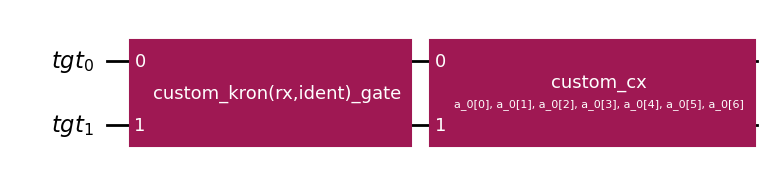

In [3]:
q_env.unwrapped.circuit_truncations[0].draw('mpl')

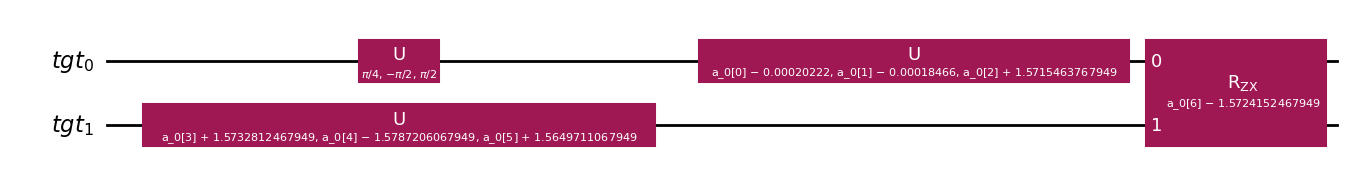

In [4]:
q_env.unwrapped.circuit_truncations[0].decompose().draw('mpl')

In [5]:
current_dir = os.getcwd()

path_agent_config = os.path.join(os.path.dirname(os.path.dirname(current_dir)), "agent_config.yaml")
path_hpo_config = os.path.join(os.path.dirname(current_dir), "hpo_config.yaml")
save_results_path = "hpo_results"

In [6]:
experimental_penalty_weights = {
    'runtime': 0.01,
    'n_shots': 0.01,
    'batchsize': 0.01,
    'sample_paulis': 0.015,
}

In [7]:
optimizer = HyperparameterOptimizer(
    q_env=q_env,
    path_agent_config=path_agent_config,
    path_hpo_config=path_hpo_config,
    save_results_path=save_results_path,
    experimental_penalty_weights=experimental_penalty_weights,
    log_progress=False,
)

In [8]:
best_trial = optimizer.optimize_hyperparameters(num_hpo_trials=2)

 95%|█████████▍| 700/740 [03:00<00:10,  3.84it/s]

Starting benchmarking...
Fidelity stored 0.9999775872536876
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IY', 'IZ', 'XI', 'XY', 'XZ'],
              coeffs=[ 0.5       +0.j, -0.70710678+0.j,  0.70710678+0.j,  0.5       +0.j,
 -0.70710678+0.j,  0.70710678+0.j])
Finished Estimator job


 95%|█████████▍| 701/740 [03:00<00:10,  3.87it/s]

mean tensor([ 0.0084,  0.3087, -0.2745, -0.0797,  0.0662,  0.0348,  0.0528])
sigma tensor([0.0740, 0.0145, 0.0229, 0.0161, 0.0147, 0.0268, 0.0159])
DFE Rewards Mean: 0.49992019380802094
DFE Rewards standard dev 0.0009711939097173274
Returns Mean: 0.69298947
Returns standard dev: 0.001941936
Advantages Mean: 0.012251018
Advantages standard dev 0.001941936
Starting benchmarking...
Fidelity stored 0.999985408949138
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IY', 'IZ', 'XI', 'XY', 'XZ'],
              coeffs=[0.5       +0.j, 0.70710678+0.j, 0.70710678+0.j, 0.5       +0.j,
 0.70710678+0.j, 0.70710678+0.j])
Finished Estimator job


 95%|█████████▍| 702/740 [03:00<00:09,  3.88it/s]

mean tensor([ 0.0396,  0.3113, -0.3231, -0.0722,  0.0907,  0.0530,  0.0460])
sigma tensor([0.0513, 0.0085, 0.0130, 0.0082, 0.0083, 0.0137, 0.0083])
DFE Rewards Mean: 0.4999536415801013
DFE Rewards standard dev 0.001102243580217808
Returns Mean: 0.69305694
Returns standard dev: 0.00220425
Advantages Mean: -0.02225892
Advantages standard dev 0.00220425
Starting benchmarking...
Fidelity stored 0.9999815688614956
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XY', 'YX', 'ZI', 'ZZ'],
              coeffs=[ 0.5       +0.j, -0.70710678+0.j,  0.70710678+0.j,  0.70710678+0.j,
 -0.70710678+0.j,  0.5       +0.j])
Finished Estimator job


 95%|█████████▌| 703/740 [03:01<00:09,  3.92it/s]

mean tensor([ 0.0123,  0.3093, -0.2845, -0.0783,  0.0736,  0.0400,  0.0507])
sigma tensor([0.0678, 0.0153, 0.0213, 0.0150, 0.0138, 0.0240, 0.0141])
DFE Rewards Mean: 0.4999892764216088
DFE Rewards standard dev 0.001041035414718916
Returns Mean: 0.6931279
Returns standard dev: 0.00208165
Advantages Mean: 0.01617971
Advantages standard dev 0.00208165
Starting benchmarking...
Fidelity stored 0.9999866748692992
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IX', 'XI', 'XX'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])
Finished Estimator job


 95%|█████████▌| 704/740 [03:01<00:09,  3.97it/s]

mean tensor([ 0.0246,  0.3119, -0.3061, -0.0738,  0.0882,  0.0494,  0.0478])
sigma tensor([0.0522, 0.0109, 0.0152, 0.0106, 0.0100, 0.0166, 0.0095])
DFE Rewards Mean: 0.4999989756252454
DFE Rewards standard dev 3.7011720371613855e-06
Returns Mean: 0.69314516
Returns standard dev: 7.402123e-06
Advantages Mean: -0.017722212
Advantages standard dev 7.4020886e-06
Starting benchmarking...
Fidelity stored 0.999976410452997
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XY', 'YX', 'ZI', 'ZZ'],
              coeffs=[ 0.5       +0.j,  0.70710678+0.j, -0.70710678+0.j, -0.70710678+0.j,
  0.70710678+0.j,  0.5       +0.j])
Finished Estimator job


 95%|█████████▌| 705/740 [03:01<00:08,  3.99it/s]

mean tensor([-0.0121,  0.3089, -0.2644, -0.0797,  0.0693,  0.0390,  0.0566])
sigma tensor([0.0706, 0.0195, 0.0252, 0.0190, 0.0156, 0.0272, 0.0188])
DFE Rewards Mean: 0.4999602584681134
DFE Rewards standard dev 0.0009847449652892071
Returns Mean: 0.6930696
Returns standard dev: 0.001968778
Advantages Mean: 0.025071863
Advantages standard dev 0.001968778
Starting benchmarking...
Fidelity stored 0.9999797887798874
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IY', 'IZ', 'XI', 'XY', 'XZ'],
              coeffs=[ 0.5       +0.j, -0.70710678+0.j,  0.70710678+0.j,  0.5       +0.j,
 -0.70710678+0.j,  0.70710678+0.j])
Finished Estimator job


 95%|█████████▌| 706/740 [03:01<00:08,  4.03it/s]

mean tensor([-0.0150,  0.3106, -0.2697, -0.0827,  0.0723,  0.0392,  0.0520])
sigma tensor([0.0638, 0.0174, 0.0236, 0.0167, 0.0141, 0.0258, 0.0172])
DFE Rewards Mean: 0.500058355336758
DFE Rewards standard dev 0.0010800123267150376
Returns Mean: 0.6932662
Returns standard dev: 0.0021604206
Advantages Mean: -0.001306157
Advantages standard dev 0.0021604206
Starting benchmarking...
Fidelity stored 0.9999884756028714
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IX', 'XI', 'XX'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])
Finished Estimator job


 96%|█████████▌| 707/740 [03:02<00:08,  4.06it/s]

mean tensor([ 0.0101,  0.3108, -0.2969, -0.0758,  0.0856,  0.0522,  0.0441])
sigma tensor([0.0490, 0.0109, 0.0169, 0.0102, 0.0102, 0.0173, 0.0122])
DFE Rewards Mean: 0.49999865548750766
DFE Rewards standard dev 4.015703052876474e-06
Returns Mean: 0.6931445
Returns standard dev: 8.030844e-06
Advantages Mean: -0.015783615
Advantages standard dev 8.03084e-06
Starting benchmarking...
Fidelity stored 0.9999790427037591
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IY', 'IZ', 'XI', 'XY', 'XZ'],
              coeffs=[ 0.5       +0.j, -0.70710678+0.j,  0.70710678+0.j,  0.5       +0.j,
 -0.70710678+0.j,  0.70710678+0.j])
Finished Estimator job


 96%|█████████▌| 708/740 [03:02<00:07,  4.03it/s]

mean tensor([-0.0169,  0.3130, -0.2682, -0.0825,  0.0695,  0.0382,  0.0494])
sigma tensor([0.0620, 0.0156, 0.0234, 0.0163, 0.0141, 0.0246, 0.0190])
DFE Rewards Mean: 0.4999623736921623
DFE Rewards standard dev 0.001041384414642363
Returns Mean: 0.6930741
Returns standard dev: 0.0020825933
Advantages Mean: 0.01242321
Advantages standard dev 0.0020825933
Starting benchmarking...
Fidelity stored 0.9999816693697314
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XY', 'YX', 'ZI', 'ZZ'],
              coeffs=[ 0.5       +0.j, -0.70710678+0.j,  0.70710678+0.j,  0.70710678+0.j,
 -0.70710678+0.j,  0.5       +0.j])
Finished Estimator job


 96%|█████████▌| 709/740 [03:02<00:07,  4.01it/s]

mean tensor([-0.0134,  0.3132, -0.2738, -0.0816,  0.0757,  0.0442,  0.0467])
sigma tensor([0.0576, 0.0129, 0.0209, 0.0150, 0.0128, 0.0216, 0.0171])
DFE Rewards Mean: 0.49995404344661154
DFE Rewards standard dev 0.0012030727002758377
Returns Mean: 0.69305813
Returns standard dev: 0.0024060034
Advantages Mean: -0.0007571911
Advantages standard dev 0.0024060025
Starting benchmarking...
Fidelity stored 0.9999878621937323
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IX', 'XI', 'XX'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])
Finished Estimator job


 96%|█████████▌| 710/740 [03:02<00:07,  4.01it/s]

mean tensor([-0.0008,  0.3147, -0.2977, -0.0767,  0.0846,  0.0566,  0.0353])
sigma tensor([0.0483, 0.0087, 0.0153, 0.0108, 0.0104, 0.0159, 0.0134])
DFE Rewards Mean: 0.4999991213126877
DFE Rewards standard dev 3.358784582324958e-06
Returns Mean: 0.6931454
Returns standard dev: 6.717653e-06
Advantages Mean: -0.013996214
Advantages standard dev 6.717588e-06
Starting benchmarking...
Fidelity stored 0.9999892615233554
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XY', 'YX', 'ZI', 'ZZ'],
              coeffs=[0.5       +0.j, 0.70710678+0.j, 0.70710678+0.j, 0.70710678+0.j,
 0.70710678+0.j, 0.5       +0.j])
Finished Estimator job


 96%|█████████▌| 711/740 [03:03<00:07,  4.01it/s]

mean tensor([-0.0032,  0.3156, -0.3055, -0.0740,  0.0855,  0.0601,  0.0338])
sigma tensor([0.0464, 0.0074, 0.0129, 0.0095, 0.0089, 0.0125, 0.0116])
DFE Rewards Mean: 0.4999927751067136
DFE Rewards standard dev 0.0010917058329950747
Returns Mean: 0.69313514
Returns standard dev: 0.0021832325
Advantages Mean: -0.0043646363
Advantages standard dev 0.0021832325
Starting benchmarking...


 96%|█████████▌| 712/740 [03:03<00:08,  3.41it/s]

Fidelity stored 0.9999805318368515
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XY', 'YI', 'YZ', 'ZX'],
              coeffs=[ 0.5       +0.j,  0.70710678+0.j, -0.70710678+0.j,  0.70710678+0.j,
  0.5       +0.j,  0.70710678+0.j])
Finished Estimator job
mean tensor([-0.0258,  0.3191, -0.2716, -0.0800,  0.0728,  0.0417,  0.0430])
sigma tensor([0.0594, 0.0127, 0.0204, 0.0154, 0.0136, 0.0205, 0.0181])
DFE Rewards Mean: 0.4999948026542934
DFE Rewards standard dev 0.0012460510473162865
Returns Mean: 0.6931399
Returns standard dev: 0.0024929114
Advantages Mean: 0.012617689
Advantages standard dev 0.0024929114
Starting benchmarking...


 96%|█████████▋| 713/740 [03:03<00:07,  3.57it/s]

Fidelity stored 0.9999861160152894
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XY', 'YI', 'YZ', 'ZX'],
              coeffs=[ 0.5       +0.j, -0.70710678+0.j,  0.70710678+0.j, -0.70710678+0.j,
  0.5       +0.j, -0.70710678+0.j])
Finished Estimator job
mean tensor([-0.0115,  0.3209, -0.2912, -0.0751,  0.0829,  0.0487,  0.0408])
sigma tensor([0.0536, 0.0120, 0.0161, 0.0128, 0.0110, 0.0158, 0.0146])
DFE Rewards Mean: 0.49998969529847637
DFE Rewards standard dev 0.0010876603307592122
Returns Mean: 0.69312894
Returns standard dev: 0.0021753833
Advantages Mean: -0.011649967
Advantages standard dev 0.0021753819
Starting benchmarking...


 96%|█████████▋| 714/740 [03:03<00:06,  3.72it/s]

Fidelity stored 0.9999888880956449
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XY', 'YX', 'ZI', 'ZZ'],
              coeffs=[0.5       +0.j, 0.70710678+0.j, 0.70710678+0.j, 0.70710678+0.j,
 0.70710678+0.j, 0.5       +0.j])
Finished Estimator job
mean tensor([ 0.0003,  0.3200, -0.3126, -0.0700,  0.0933,  0.0579,  0.0368])
sigma tensor([0.0497, 0.0092, 0.0127, 0.0105, 0.0091, 0.0125, 0.0118])
DFE Rewards Mean: 0.4999923121218657
DFE Rewards standard dev 0.0010605585361343514
Returns Mean: 0.69313407
Returns standard dev: 0.0021212054
Advantages Mean: -0.0063377763
Advantages standard dev 0.0021212054
Starting benchmarking...


 97%|█████████▋| 715/740 [03:04<00:06,  3.84it/s]

Fidelity stored 0.9999764305490351
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IY', 'IZ', 'XI', 'XY', 'XZ'],
              coeffs=[ 0.5       +0.j, -0.70710678+0.j,  0.70710678+0.j,  0.5       +0.j,
 -0.70710678+0.j,  0.70710678+0.j])
Finished Estimator job
mean tensor([-0.0237,  0.3198, -0.2691, -0.0798,  0.0722,  0.0410,  0.0429])
sigma tensor([0.0671, 0.0146, 0.0214, 0.0180, 0.0148, 0.0214, 0.0204])
DFE Rewards Mean: 0.4998864572872316
DFE Rewards standard dev 0.001102803219312129
Returns Mean: 0.69292253
Returns standard dev: 0.002205165
Advantages Mean: 0.01391932
Advantages standard dev 0.0022051649
Starting benchmarking...


 97%|█████████▋| 716/740 [03:04<00:06,  3.94it/s]

Fidelity stored 0.9999739004639683
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IY', 'IZ', 'XI', 'XY', 'XZ'],
              coeffs=[ 0.5       +0.j, -0.70710678+0.j,  0.70710678+0.j,  0.5       +0.j,
 -0.70710678+0.j,  0.70710678+0.j])
Finished Estimator job
mean tensor([-0.0263,  0.3210, -0.2686, -0.0779,  0.0737,  0.0401,  0.0393])
sigma tensor([0.0706, 0.0151, 0.0215, 0.0182, 0.0146, 0.0235, 0.0220])
DFE Rewards Mean: 0.5000199649007144
DFE Rewards standard dev 0.0010699343956090152
Returns Mean: 0.6931894
Returns standard dev: 0.002140042
Advantages Mean: 0.0014996124
Advantages standard dev 0.0021400417
Starting benchmarking...


 97%|█████████▋| 717/740 [03:04<00:05,  3.96it/s]

Fidelity stored 0.9999882678289812
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IY', 'IZ', 'XI', 'XY', 'XZ'],
              coeffs=[0.5       +0.j, 0.70710678+0.j, 0.70710678+0.j, 0.5       +0.j,
 0.70710678+0.j, 0.70710678+0.j])
Finished Estimator job
mean tensor([-0.0003,  0.3224, -0.3203, -0.0709,  0.0925,  0.0576,  0.0309])
sigma tensor([0.0528, 0.0082, 0.0107, 0.0105, 0.0084, 0.0120, 0.0115])
DFE Rewards Mean: 0.500009996093117
DFE Rewards standard dev 0.0011712326983093979
Returns Mean: 0.69316995
Returns standard dev: 0.0023418816
Advantages Mean: -0.020365154
Advantages standard dev 0.0023418816
Starting benchmarking...


 97%|█████████▋| 718/740 [03:04<00:05,  3.94it/s]

Fidelity stored 0.9999805933726531
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IY', 'IZ', 'XI', 'XY', 'XZ'],
              coeffs=[ 0.5       +0.j,  0.70710678+0.j, -0.70710678+0.j,  0.5       +0.j,
  0.70710678+0.j, -0.70710678+0.j])
Finished Estimator job
mean tensor([-0.0180,  0.3268, -0.2926, -0.0788,  0.0758,  0.0427,  0.0362])
sigma tensor([0.0626, 0.0121, 0.0158, 0.0149, 0.0120, 0.0184, 0.0169])
DFE Rewards Mean: 0.49997320163451375
DFE Rewards standard dev 0.0011980507360667156
Returns Mean: 0.6930965
Returns standard dev: 0.0023965067
Advantages Mean: 0.0040643783
Advantages standard dev 0.0023965065
Starting benchmarking...


 97%|█████████▋| 719/740 [03:05<00:05,  3.96it/s]

Fidelity stored 0.9999887507299887
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XY', 'YI', 'YZ', 'ZX'],
              coeffs=[ 0.5       +0.j,  0.70710678+0.j,  0.70710678+0.j,  0.70710678+0.j,
  0.5       +0.j, -0.70710678+0.j])
Finished Estimator job
mean tensor([ 0.0035,  0.3245, -0.3248, -0.0715,  0.0882,  0.0556,  0.0317])
sigma tensor([0.0510, 0.0083, 0.0121, 0.0103, 0.0086, 0.0119, 0.0112])
DFE Rewards Mean: 0.5000066313252305
DFE Rewards standard dev 0.0010318195187203393
Returns Mean: 0.69316256
Returns standard dev: 0.0020635803
Advantages Mean: -0.002150524
Advantages standard dev 0.0020635803
Starting benchmarking...


 97%|█████████▋| 720/740 [03:05<00:04,  4.01it/s]

Fidelity stored 0.9999816914645318
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'XX', 'YY', 'ZZ'],
              coeffs=[ 0.5+0.j,  0.5+0.j, -0.5+0.j,  0.5+0.j])
Finished Estimator job
mean tensor([-0.0172,  0.3288, -0.3006, -0.0793,  0.0764,  0.0416,  0.0359])
sigma tensor([0.0605, 0.0116, 0.0169, 0.0140, 0.0112, 0.0175, 0.0154])
DFE Rewards Mean: 0.4999961634039799
DFE Rewards standard dev 6.400683399333047e-06
Returns Mean: 0.6931395
Returns standard dev: 1.2802835e-05
Advantages Mean: -0.00070111547
Advantages standard dev 1.2802829e-05
Starting benchmarking...


 97%|█████████▋| 721/740 [03:05<00:04,  4.03it/s]

Fidelity stored 0.9999864604437552
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'XX', 'YZ', 'ZY'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])
Finished Estimator job
mean tensor([-0.0075,  0.3284, -0.3147, -0.0717,  0.0815,  0.0474,  0.0326])
sigma tensor([0.0563, 0.0095, 0.0143, 0.0108, 0.0087, 0.0149, 0.0129])
DFE Rewards Mean: 0.49999743019115106
DFE Rewards standard dev 4.934172864120204e-06
Returns Mean: 0.69314206
Returns standard dev: 9.8672635e-06
Advantages Mean: -0.0030124325
Advantages standard dev 9.8672535e-06
Starting benchmarking...


 98%|█████████▊| 722/740 [03:05<00:04,  4.04it/s]

Fidelity stored 0.999970339430805
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XY', 'YX', 'ZI', 'ZZ'],
              coeffs=[ 0.5       +0.j,  0.70710678+0.j, -0.70710678+0.j, -0.70710678+0.j,
  0.70710678+0.j,  0.5       +0.j])
Finished Estimator job
mean tensor([-0.0310,  0.3319, -0.2736, -0.0843,  0.0579,  0.0266,  0.0414])
sigma tensor([0.0703, 0.0163, 0.0235, 0.0173, 0.0148, 0.0260, 0.0210])
DFE Rewards Mean: 0.49997475548840603
DFE Rewards standard dev 0.0012363869711307731
Returns Mean: 0.69309974
Returns standard dev: 0.002472516
Advantages Mean: 0.010485901
Advantages standard dev 0.002472516
Starting benchmarking...


 98%|█████████▊| 723/740 [03:06<00:04,  4.06it/s]

Fidelity stored 0.9999882033364161
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XY', 'YX', 'ZI', 'ZZ'],
              coeffs=[0.5       +0.j, 0.70710678+0.j, 0.70710678+0.j, 0.70710678+0.j,
 0.70710678+0.j, 0.5       +0.j])
Finished Estimator job
mean tensor([-0.0021,  0.3282, -0.3230, -0.0690,  0.0786,  0.0510,  0.0309])
sigma tensor([0.0574, 0.0096, 0.0125, 0.0103, 0.0086, 0.0150, 0.0112])
DFE Rewards Mean: 0.49996998311938334
DFE Rewards standard dev 0.0011308874709463955
Returns Mean: 0.6930897
Returns standard dev: 0.002261357
Advantages Mean: -0.010837155
Advantages standard dev 0.002261357
Starting benchmarking...


 98%|█████████▊| 724/740 [03:06<00:03,  4.06it/s]

Fidelity stored 0.9999882432312086
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XY', 'YX', 'ZI', 'ZZ'],
              coeffs=[ 0.5       +0.j,  0.70710678+0.j,  0.70710678+0.j, -0.70710678+0.j,
 -0.70710678+0.j, -0.5       +0.j])
Finished Estimator job
mean tensor([-0.0026,  0.3273, -0.3284, -0.0659,  0.0808,  0.0463,  0.0286])
sigma tensor([0.0573, 0.0091, 0.0124, 0.0095, 0.0079, 0.0145, 0.0107])
DFE Rewards Mean: 0.49997511685368695
DFE Rewards standard dev 0.0010192579905828523
Returns Mean: 0.6930995
Returns standard dev: 0.0020385035
Advantages Mean: -0.00066269096
Advantages standard dev 0.0020385038
Starting benchmarking...


 98%|█████████▊| 725/740 [03:06<00:03,  4.11it/s]

Fidelity stored 0.9999733202210644
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XY', 'YI', 'YZ', 'ZX'],
              coeffs=[ 0.5       +0.j,  0.70710678+0.j, -0.70710678+0.j,  0.70710678+0.j,
  0.5       +0.j,  0.70710678+0.j])
Finished Estimator job
mean tensor([-0.0342,  0.3319, -0.2920, -0.0791,  0.0627,  0.0274,  0.0299])
sigma tensor([0.0693, 0.0145, 0.0199, 0.0154, 0.0121, 0.0242, 0.0168])
DFE Rewards Mean: 0.5000103531062781
DFE Rewards standard dev 0.0010457100419254425
Returns Mean: 0.6931701
Returns standard dev: 0.0020914953
Advantages Mean: 0.0051852507
Advantages standard dev 0.0020914953
Starting benchmarking...


 98%|█████████▊| 726/740 [03:06<00:03,  4.13it/s]

Fidelity stored 0.9999854462266303
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IX', 'XI', 'XX'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])
Finished Estimator job
mean tensor([-0.0068,  0.3325, -0.3193, -0.0696,  0.0778,  0.0432,  0.0274])
sigma tensor([0.0592, 0.0099, 0.0129, 0.0108, 0.0084, 0.0171, 0.0121])
DFE Rewards Mean: 0.4999989314169748
DFE Rewards standard dev 3.6325493967136316e-06
Returns Mean: 0.69314504
Returns standard dev: 7.265756e-06
Advantages Mean: -0.009512955
Advantages standard dev 7.265754e-06
Starting benchmarking...


 98%|█████████▊| 727/740 [03:07<00:03,  4.09it/s]

Fidelity stored 0.9999781574282236
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XY', 'YX', 'ZI', 'ZZ'],
              coeffs=[ 0.5       +0.j, -0.70710678+0.j,  0.70710678+0.j, -0.70710678+0.j,
  0.70710678+0.j, -0.5       +0.j])
Finished Estimator job
mean tensor([-0.0258,  0.3344, -0.2995, -0.0745,  0.0688,  0.0336,  0.0289])
sigma tensor([0.0701, 0.0119, 0.0161, 0.0129, 0.0101, 0.0211, 0.0148])
DFE Rewards Mean: 0.4999525254656585
DFE Rewards standard dev 0.0010431672442756603
Returns Mean: 0.69305444
Returns standard dev: 0.002086053
Advantages Mean: 0.003528927
Advantages standard dev 0.002086053
Starting benchmarking...


 98%|█████████▊| 728/740 [03:07<00:02,  4.09it/s]

Fidelity stored 0.9999869760194814
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'XX', 'YZ', 'ZY'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])
Finished Estimator job
mean tensor([-0.0028,  0.3330, -0.3241, -0.0684,  0.0820,  0.0476,  0.0275])
sigma tensor([0.0614, 0.0091, 0.0123, 0.0098, 0.0080, 0.0171, 0.0106])
DFE Rewards Mean: 0.4999979220068342
DFE Rewards standard dev 5.5536619394335165e-06
Returns Mean: 0.693143
Returns standard dev: 1.1108372e-05
Advantages Mean: -0.005009517
Advantages standard dev 1.1108362e-05
Starting benchmarking...


 99%|█████████▊| 729/740 [03:07<00:03,  3.48it/s]

Fidelity stored 0.9999672228035597
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XY', 'YX', 'ZI', 'ZZ'],
              coeffs=[ 0.5       +0.j,  0.70710678+0.j, -0.70710678+0.j, -0.70710678+0.j,
  0.70710678+0.j,  0.5       +0.j])
Finished Estimator job
mean tensor([-0.0316,  0.3397, -0.2812, -0.0820,  0.0607,  0.0278,  0.0391])
sigma tensor([0.0772, 0.0156, 0.0216, 0.0176, 0.0138, 0.0269, 0.0189])
DFE Rewards Mean: 0.4999325593000419
DFE Rewards standard dev 0.0011044962564223518
Returns Mean: 0.69301474
Returns standard dev: 0.002208727
Advantages Mean: 0.004286534
Advantages standard dev 0.002208727
Starting benchmarking...


 99%|█████████▊| 730/740 [03:08<00:02,  3.64it/s]

Fidelity stored 0.9999775758333462
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XY', 'YI', 'YZ', 'ZX'],
              coeffs=[ 0.5       +0.j,  0.70710678+0.j, -0.70710678+0.j,  0.70710678+0.j,
  0.5       +0.j,  0.70710678+0.j])
Finished Estimator job
mean tensor([-0.0248,  0.3392, -0.2924, -0.0767,  0.0692,  0.0350,  0.0374])
sigma tensor([0.0700, 0.0138, 0.0177, 0.0145, 0.0120, 0.0225, 0.0154])
DFE Rewards Mean: 0.49991391141368213
DFE Rewards standard dev 0.0011980776103858602
Returns Mean: 0.6929779
Returns standard dev: 0.0023959184
Advantages Mean: -0.0027151275
Advantages standard dev 0.0023959184
Starting benchmarking...


 99%|█████████▉| 731/740 [03:08<00:02,  3.72it/s]

Fidelity stored 0.999981937218611
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IY', 'IZ', 'XI', 'XY', 'XZ'],
              coeffs=[ 0.5       +0.j,  0.70710678+0.j, -0.70710678+0.j,  0.5       +0.j,
  0.70710678+0.j, -0.70710678+0.j])
Finished Estimator job
mean tensor([-0.0080,  0.3375, -0.2999, -0.0735,  0.0741,  0.0355,  0.0338])
sigma tensor([0.0619, 0.0115, 0.0147, 0.0128, 0.0106, 0.0200, 0.0141])
DFE Rewards Mean: 0.49997936771942925
DFE Rewards standard dev 0.001173396992396841
Returns Mean: 0.6931087
Returns standard dev: 0.00234704
Advantages Mean: -0.0064535737
Advantages standard dev 0.0023470388
Starting benchmarking...


 99%|█████████▉| 732/740 [03:08<00:02,  3.83it/s]

Fidelity stored 0.9999709503556546
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XY', 'YX', 'ZI', 'ZZ'],
              coeffs=[ 0.5       +0.j,  0.70710678+0.j, -0.70710678+0.j, -0.70710678+0.j,
  0.70710678+0.j,  0.5       +0.j])
Finished Estimator job
mean tensor([-0.0231,  0.3407, -0.2746, -0.0819,  0.0612,  0.0201,  0.0364])
sigma tensor([0.0698, 0.0174, 0.0222, 0.0173, 0.0150, 0.0273, 0.0212])
DFE Rewards Mean: 0.5000159605795365
DFE Rewards standard dev 0.0011841120953637364
Returns Mean: 0.69318193
Returns standard dev: 0.002368723
Advantages Mean: 0.008521592
Advantages standard dev 0.002368723
Starting benchmarking...


 99%|█████████▉| 733/740 [03:08<00:01,  3.87it/s]

Fidelity stored 0.9999889365748292
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XY', 'YX', 'ZI', 'ZZ'],
              coeffs=[ 0.5       +0.j,  0.70710678+0.j,  0.70710678+0.j, -0.70710678+0.j,
 -0.70710678+0.j, -0.5       +0.j])
Finished Estimator job
mean tensor([ 0.0072,  0.3360, -0.3233, -0.0610,  0.0871,  0.0505,  0.0273])
sigma tensor([0.0540, 0.0089, 0.0109, 0.0089, 0.0092, 0.0135, 0.0109])
DFE Rewards Mean: 0.500032155642853
DFE Rewards standard dev 0.0010879117397668329
Returns Mean: 0.6932138
Returns standard dev: 0.0021758075
Advantages Mean: -0.012306471
Advantages standard dev 0.0021758075
Starting benchmarking...


 99%|█████████▉| 734/740 [03:09<00:01,  3.94it/s]

Fidelity stored 0.9999865388667762
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'XX', 'YZ', 'ZY'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])
Finished Estimator job
mean tensor([-0.0014,  0.3360, -0.3133, -0.0638,  0.0842,  0.0470,  0.0299])
sigma tensor([0.0589, 0.0098, 0.0128, 0.0097, 0.0103, 0.0146, 0.0131])
DFE Rewards Mean: 0.49999734400850415
DFE Rewards standard dev 5.872802352493381e-06
Returns Mean: 0.6931419
Returns standard dev: 1.1745145e-05
Advantages Mean: 0.0053037917
Advantages standard dev 1.1745143e-05
Starting benchmarking...


 99%|█████████▉| 735/740 [03:09<00:01,  4.00it/s]

Fidelity stored 0.9999687008967743
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XY', 'YX', 'ZI', 'ZZ'],
              coeffs=[ 0.5       +0.j,  0.70710678+0.j, -0.70710678+0.j, -0.70710678+0.j,
  0.70710678+0.j,  0.5       +0.j])
Finished Estimator job
mean tensor([-0.0335,  0.3373, -0.2772, -0.0815,  0.0600,  0.0232,  0.0353])
sigma tensor([0.0738, 0.0173, 0.0235, 0.0176, 0.0167, 0.0242, 0.0221])
DFE Rewards Mean: 0.49997958600384773
DFE Rewards standard dev 0.0011914780306690519
Returns Mean: 0.6931092
Returns standard dev: 0.0023832698
Advantages Mean: 0.0097108865
Advantages standard dev 0.0023832698
Starting benchmarking...


 99%|█████████▉| 736/740 [03:09<00:00,  4.01it/s]

Fidelity stored 0.9999881908799099
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XY', 'YI', 'YZ', 'ZX'],
              coeffs=[ 0.5       +0.j,  0.70710678+0.j,  0.70710678+0.j,  0.70710678+0.j,
  0.5       +0.j, -0.70710678+0.j])
Finished Estimator job
mean tensor([-0.0017,  0.3277, -0.3305, -0.0615,  0.0966,  0.0541,  0.0290])
sigma tensor([0.0546, 0.0081, 0.0109, 0.0081, 0.0106, 0.0104, 0.0112])
DFE Rewards Mean: 0.49997945827790535
DFE Rewards standard dev 0.0011295124317203394
Returns Mean: 0.6931086
Returns standard dev: 0.0022591494
Advantages Mean: -0.017731098
Advantages standard dev 0.0022591494
Starting benchmarking...


100%|█████████▉| 737/740 [03:09<00:00,  4.03it/s]

Fidelity stored 0.9999867458933712
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XY', 'YX', 'ZI', 'ZZ'],
              coeffs=[0.5       +0.j, 0.70710678+0.j, 0.70710678+0.j, 0.70710678+0.j,
 0.70710678+0.j, 0.5       +0.j])
Finished Estimator job
mean tensor([-0.0139,  0.3277, -0.3202, -0.0660,  0.0877,  0.0491,  0.0349])
sigma tensor([0.0569, 0.0103, 0.0142, 0.0107, 0.0122, 0.0135, 0.0127])
DFE Rewards Mean: 0.5000303064756708
DFE Rewards standard dev 0.0010858565568453383
Returns Mean: 0.6932101
Returns standard dev: 0.0021718824
Advantages Mean: -0.0030597756
Advantages standard dev 0.0021718824
Starting benchmarking...


100%|█████████▉| 738/740 [03:10<00:00,  4.03it/s]

Fidelity stored 0.9999856661648059
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'XX', 'YY', 'ZZ'],
              coeffs=[ 0.5+0.j,  0.5+0.j,  0.5+0.j, -0.5+0.j])
Finished Estimator job
mean tensor([-0.0105,  0.3291, -0.3102, -0.0702,  0.0812,  0.0454,  0.0321])
sigma tensor([0.0607, 0.0120, 0.0159, 0.0119, 0.0136, 0.0157, 0.0142])
DFE Rewards Mean: 0.49999744985896
DFE Rewards standard dev 5.4713783166195635e-06
Returns Mean: 0.69314206
Returns standard dev: 1.09427665e-05
Advantages Mean: 0.0023213273
Advantages standard dev 1.0942739e-05
Starting benchmarking...


100%|█████████▉| 739/740 [03:10<00:00,  4.02it/s]

Fidelity stored 0.9999802172174815
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IY', 'IZ', 'XI', 'XY', 'XZ'],
              coeffs=[ 0.5       +0.j,  0.70710678+0.j, -0.70710678+0.j,  0.5       +0.j,
  0.70710678+0.j, -0.70710678+0.j])
Finished Estimator job
mean tensor([-0.0234,  0.3339, -0.2999, -0.0750,  0.0723,  0.0352,  0.0351])
sigma tensor([0.0642, 0.0135, 0.0171, 0.0129, 0.0149, 0.0178, 0.0158])
DFE Rewards Mean: 0.5000021894708468
DFE Rewards standard dev 0.0010446627140559216
Returns Mean: 0.69315374
Returns standard dev: 0.0020893433
Advantages Mean: 0.0019043726
Advantages standard dev 0.0020893433
Starting benchmarking...


100%|██████████| 740/740 [03:10<00:00,  3.88it/s]
[I 2024-03-19 16:02:54,134] Trial 1 finished with value: 16.505403937269918 and parameters: {'N_UPDATES': 740, 'N_EPOCHS': 14, 'MINIBATCH_SIZE': 64, 'BATCHSIZE_MULTIPLIER': 8, 'LR': 0.0003447527420061122, 'N_SHOTS': 798, 'SAMPLE_PAULIS': 100, 'GAMMA': 0.997111647771325, 'GAE_LAMBDA': 0.9825383450153168, 'ENT_COEF': 0.0005963626909089036, 'V_COEF': 0.487521054952765, 'GRADIENT_CLIP': 0.16689017830436123, 'CLIP_VALUE_COEF': 0.24008818182813887, 'CLIP_RATIO': 0.2708534167300696}. Best is trial 1 with value: 16.505403937269918.


Fidelity stored 0.9999716595305536
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IY', 'IZ', 'XI', 'XY', 'XZ'],
              coeffs=[ 0.5       +0.j, -0.70710678+0.j,  0.70710678+0.j,  0.5       +0.j,
 -0.70710678+0.j,  0.70710678+0.j])
Finished Estimator job
mean tensor([-0.0305,  0.3360, -0.2872, -0.0811,  0.0643,  0.0283,  0.0352])
sigma tensor([0.0736, 0.0169, 0.0213, 0.0160, 0.0181, 0.0220, 0.0189])
DFE Rewards Mean: 0.49992252161658407
DFE Rewards standard dev 0.0011246582800799648
Returns Mean: 0.6929948
Returns standard dev: 0.002249162
Advantages Mean: 0.0012379213
Advantages standard dev 0.002249162
2024-03-19 16:02:54 INFO Best configuration saved to hpo_results/custom_cost_value_16.505404_timestamp_19-03-2024-16-02-54.pickle


In [9]:
best_trial

{'training_results': {'avg_reward': [0.49847463241284146,
   0.4987250795884508,
   0.49882298708014094,
   0.4989227280226051,
   0.49914268772613113,
   0.4992662171383031,
   0.4994501130646862,
   0.4993739463199094,
   0.49940655498135944,
   0.4995111088274502,
   0.49968649807705856,
   0.4997270126991517,
   0.4996093989542529,
   0.499653179210114,
   0.4997257920248396,
   0.4998163170137958,
   0.4998206015131986,
   0.4998496885980798,
   0.499891024022183,
   0.49979055518576027,
   0.4998466613342435,
   0.4998740737562827,
   0.4998172899067297,
   0.49992417492703717,
   0.49987543448250205,
   0.4999017584012734,
   0.49993739330455333,
   0.5000372687137933,
   0.49991184062188254,
   0.49992961417206083,
   0.49995064560531804,
   0.4999661538876743,
   0.49989848370349677,
   0.4998953126101354,
   0.49995090420441196,
   0.5000570409507167,
   0.5000321811754631,
   0.4999785273149367,
   0.4998998748377478,
   0.49998615112210026,
   0.49989849093812855,
   0.4999